In [39]:
import numpy as np
import glob
import cv2
from moviepy.editor import VideoFileClip
import matplotlib.pyplot as plt

def showImage(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(image)
    plt.show()

In [12]:
"""
This class contain all the hyperparameter that we have to tune to get the best result 
"""
class Config:
    def __init__(self):
        #CAMERA CALIBRATION 
        self.CHESSBOARD_SIZE = (9, 6)

        #COLOR AND GRADIENT SPACE
        self.SOBEL_KERNEL_SIZE = 15
        self.ABSOLUTE_GRADIENT_THRESHOLD = (30, 100)
        self.MAGNITUDE_GRADIENT_THRESHOLD = (30, 100)
        self.DIRECTION_GRADIENT_THRESHOLD = (0.7, 1.3)
        self.COLOR_CHANNEL = 'S'
        self.COLOR_CHANNEL_THRESHOLD = (170, 255)

        #PERSPECTIVE TRANSFORMATION
        self.PERSPECTIVE_SRC = np.float32([
            [580, 460],
            [205, 720],
            [1110, 720],
            [703, 460]
        ])
        self.PERSPECTIVE_DST = np.float32([
            [250, 0],
            [250, 720],
            [960, 720],
            [960, 0]
        ])

        #FINAL LANE DETECTION USING SLIDING WINDOW
        self.NUMBER_OF_WINDOWS = 9
        self.WINDOW_MARGIN = 100
        self.MINIMUM_PIXEL_IN_WINDOW = 50
        self.METER_PER_PIXEL_X = 3.7/700
        self.METER_PER_PIXEL_Y = 32.0/720
        self.N_FRAMES = 25

In [13]:
class CameraCalibration:

    def __init__(self, calib_image_dir, chessboard_size):
        self.chessboard_size = chessboard_size
        self.calib_image_dir = calib_image_dir
        self.objectPoints = []
        self.imagePoints = []

        self.setCalibrationPoints()

    def setCalibrationPoints (self):
        
        # define 3d object point of chessboard_size 
        objectP = np.zeros((self.chessboard_size[0]*self.chessboard_size[1], 3), np.float32)
        objectP[:,:2] = np.mgrid[0:self.chessboard_size[0], 0:self.chessboard_size[1]].T.reshape(-1, 2)
        images = glob.glob(self.calib_image_dir + '*')

        for fname in images:
            image = cv2.imread(fname)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            #find corners from the chessboard images
            ret, corners = cv2.findChessboardCorners(gray, self.chessboard_size, None)

            if ret == True:
                self.objectPoints.append(objectP)
                self.imagePoints.append(corners)

                cv2.drawChessboardCorners(image, self.chessboard_size, corners, ret)

    def undistortImage (self, image):
        
        imageSize = (image.shape[1], image.shape[0])
        #compute camera matrix and distortion coefficients
        ret, camera_matrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(self.objectPoints, self.imagePoints, imageSize, None, None)

        undistorted_image = cv2.undistort(image, camera_matrix, distCoeffs, None, camera_matrix)

        return undistorted_image


In [28]:
"""
Below class compute color and gradient threshold of the image
"""
class ColorGradientSpace:
    def __init__ (self, absGradThreshold=(0,255), magGradThreshold=(0,255),
                  dirGradThreshold=(0,255), colorThreshold=(0,255), kernel_size=3, colorChannel='S'):
        self.absGradThreshold = absGradThreshold
        self.magGradThreshold = magGradThreshold
        self.dirGradThreshold = dirGradThreshold
        self.colorThreshold = colorThreshold
        colorChannelDict = {'H': 0, 'L': 1, 'S': 2}
        self.colorChannel = colorChannelDict[colorChannel]
        self.sobel_kernel = kernel_size

    def absoluteGradient (self, image, orient='x', thresh=(0,255)):

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        sobel = None
        if orient == 'x':
            sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=self.sobel_kernel)
        else:
            sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=self.sobel_kernel)
        
        abs_sobel = np.absolute(sobel)
        scaled_img = np.uint8(255.0*abs_sobel/np.max(abs_sobel))
        grad_binary = np.zeros_like(scaled_img)
        grad_binary[(scaled_img <= thresh[1]) & (scaled_img >= thresh[0])] = 255
        
        return grad_binary

    def magnitudeGradient (self, image, thresh=(0, 255)):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=self.sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=self.sobel_kernel)
        
        abs_sobel = np.sqrt(sobelx**2, sobely**2)
        scaled_img = np.uint8(255*abs_sobel/np.max(abs_sobel))

        mag_binary = np.zeros_like(scaled_img)
        mag_binary[(scaled_img <= thresh[1]) & (scaled_img >= thresh[0])] = 255
        return mag_binary

    def directionGradient (self, image, thresh=(0, np.pi/2)):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=self.sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=self.sobel_kernel)
        
        scaled_img = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

        dir_binary = np.zeros_like(scaled_img)
        dir_binary[(scaled_img <= thresh[1]) & (scaled_img >= thresh[0])] = 255

        return dir_binary
    
    def HLSChannel (self, image):
        HLSImage = cv2.cvtColor (image, cv2.COLOR_BGR2HLS)

        channel_image = HLSImage[:, :, self.colorChannel]
        binary = np.zeros_like(channel_image)
        binary[(channel_image <= self.colorThreshold[1]) & (channel_image >= self.colorThreshold[0])] = 255

        return binary
        
    def gradientCombined (self, image):

        gradx = self.absoluteGradient(image, orient='x', thresh=self.absGradThreshold)
        grady = self.absoluteGradient(image, orient='y', thresh=self.absGradThreshold)
        mag_binary = self.magnitudeGradient(image, thresh=self.magGradThreshold)
        dir_binary = self.directionGradient(image, thresh=self.dirGradThreshold)

        combined = np.zeros_like(dir_binary)
        combined[((gradx == 255) & (grady == 255)) | ((mag_binary == 255) & (dir_binary == 255))] = 255

        return combined

    def colorGradientCombined (self, image):
        #get colore threshold binary image
        colored = self.HLSChannel(image)

        #get gradient threshold binary image
        gradientCombined = self.gradientCombined(image)

        #combined the color and gradient threshold images to get the best result
        combined = np.zeros_like(gradientCombined)
        combined[(colored == 255) | (gradientCombined == 255)] = 255

        return combined

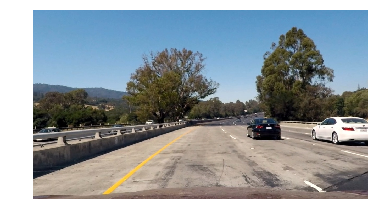

In [41]:
image = cv2.imread('./calibrated_test_images/test1.jpg')
colorGradientSpace = ColorGradientSpace()
output_image = colorGradientSpace.magnitudeGradient(image)
showImage(image)

In [15]:
class BirdEye:
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst

    def warper (self, image):

        M = cv2.getPerspectiveTransform(self.src, self.dst)
        M_inv = cv2.getPerspectiveTransform(self.dst, self.src)
        image_size = (image.shape[1], image.shape[0])

        return cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR), M_inv

In [16]:
"""
This class contain information of the line
"""
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None 
        #polynomial coefficients for the last n fit
        self.recent_fits = []
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

"""
This class detect lane from the image using sliding window technique
"""
class LaneDetect():
    def __init__(self, n_windows, margin, minpix, xm_per_pixel, ym_per_pixel, n_frames):
        self.n_windows = n_windows
        self.margin = margin
        self.minpix = minpix
        self.xm_per_pixel = xm_per_pixel
        self.ym_per_pixel = ym_per_pixel
        self.n_frames = n_frames
        self.leftLine = Line()
        self.rightLine = Line()

    def find_lane_pixels_sliding_window(self, image):
        left_lane_inds = []
        right_lane_inds = []
        window_height = np.int(image.shape[0] // self.n_windows)
        
        histogram = np.sum(image[image.shape[0]//2:, :], axis=0)

        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        nonzero = image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        leftx_current = leftx_base
        rightx_current = rightx_base
        for window in range(self.n_windows):
            win_y_low = image.shape[0] - (window+1)*window_height
            win_y_high = image.shape[0] - window*window_height

            win_leftx_low = leftx_current - self.margin
            win_leftx_high = leftx_current + self.margin
            win_rightx_low = rightx_current - self.margin
            win_rightx_high = rightx_current + self.margin 

            left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_leftx_low) &  (nonzerox < win_leftx_high)).nonzero()[0]
            right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_rightx_low) &  (nonzerox < win_rightx_high)).nonzero()[0]

            left_lane_inds.append(left_inds)
            right_lane_inds.append(right_inds)

            if len(left_inds) > self.minpix:
                leftx_current = np.int(np.mean(nonzerox[left_inds]))
            if len(right_inds) > self.minpix:
                rightx_current = np.int(np.mean(nonzerox[right_inds]))
        
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)    
        
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]    
        
        self.leftLine.allx = leftx
        self.leftLine.ally = lefty
        self.rightLine.allx = rightx
        self.rightLine.ally = righty
        
        return leftx, lefty, rightx, righty
        
    def fit_polynomial (self, image, leftx, lefty, rightx, righty):

        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
        
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        return left_fit, right_fit, left_fitx, right_fitx, ploty

    def sliding_window (self, image):
        leftx, lefty, rightx, righty = self.find_lane_pixels_sliding_window (image)

        return self.fit_polynomial(image, leftx, lefty, rightx, righty)

    def search_from_prior(self, image):
        
        nonzero = image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        left_lane_inds = ((nonzerox > (self.leftLine.current_fit[0]*(nonzeroy**2) + self.leftLine.current_fit[1]*nonzeroy + 
                    self.leftLine.current_fit[2] - self.margin)) & (nonzerox < (self.leftLine.current_fit[0]*(nonzeroy**2) + 
                    self.leftLine.current_fit[1]*nonzeroy + self.leftLine.current_fit[2] + self.margin)))
        right_lane_inds = ((nonzerox > (self.rightLine.current_fit[0]*(nonzeroy**2) + self.rightLine.current_fit[1]*nonzeroy + 
                    self.rightLine.current_fit[2] - self.margin)) & (nonzerox < (self.rightLine.current_fit[0]*(nonzeroy**2) + 
                    self.rightLine.current_fit[1]*nonzeroy + self.rightLine.current_fit[2] + self.margin)))

        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        #if lane pixel found using search prior are less than 80% of total pixels we run sliding window
        if (len(leftx) + len(rightx)) < len(nonzerox)*0.8:
            print('Searched from prior doesn\'t work searching using sliding window!')   
            return self.sliding_window(image)
        
        self.leftLine.allx = leftx
        self.leftLine.ally = lefty
        self.rightLine.allx = rightx
        self.rightLine.ally = righty

        return self.fit_polynomial(image, leftx, lefty, rightx, righty)

    def get_curvature (self, ploty):
        
        y_eval = np.max(ploty)
        left_fit_real = np.polyfit(self.leftLine.ally*self.ym_per_pixel, self.leftLine.allx*self.xm_per_pixel, 2)
        right_fit_real = np.polyfit(self.rightLine.ally*self.ym_per_pixel, self.rightLine.allx*self.xm_per_pixel, 2)

        left_curverad = ((1 + (2*left_fit_real[0]*y_eval*self.ym_per_pixel + left_fit_real[1])**2)**1.5) / np.absolute(2*left_fit_real[0])
        right_curverad = ((1 + (2*right_fit_real[0]*y_eval*self.ym_per_pixel + right_fit_real[1])**2)**1.5) / np.absolute(2*right_fit_real[0])

        return left_curverad, right_curverad

    def get_vehicle_position_text (self):
        return '{0:.2f} m towards left from centre'.format(self.leftLine.line_base_pos - self.rightLine.line_base_pos)

    def updateLine (self, line, fitx, fit, radius_of_curvature):
        
        last_fit = None
        if line.detected:
            last_fit = line.current_fit

        line.current_fit = fit

        if line.detected:
            line.diffs = last_fit - line.current_fit

        line.detected = True
        
        line.recent_fits.append(line.current_fit)
        line.recent_xfitted.append(fitx)
        if len(line.recent_xfitted) > self.n_frames:
            line.recent_xfitted = line.recent_xfitted[1:]
            line.recent_fits = line.recent_fits[1:]

        line.bestx = np.mean(line.recent_xfitted, axis=0)
        line.best_fit = np.mean(line.recent_fits, axis=0)
        line.radius_of_curvature = radius_of_curvature
        
    def detectLine (self, image):

        if self.leftLine.detected and self.rightLine.detected:
            left_fit, right_fit, left_fitx, right_fitx, ploty = self.search_from_prior(image)
        else:
            left_fit, right_fit, left_fitx, right_fitx, ploty = self.sliding_window (image)
        
        left_rc, right_rc = self.get_curvature(ploty)

        #update lane lines position with respect to center
        self.leftLine.line_base_pos = (image.shape[1]//2 - np.mean(self.leftLine.allx))*self.xm_per_pixel
        self.rightLine.line_base_pos = (np.mean(self.rightLine.allx) - image.shape[1]//2)*self.xm_per_pixel

        #update lane line information
        self.updateLine(self.leftLine, left_fitx, left_fit, left_rc)
        self.updateLine(self.rightLine, right_fitx, right_fit, right_rc)

        return self.leftLine.bestx, self.rightLine.bestx, ploty


In [17]:
class AdvancedLaneDetection ():
    def __init__(self):
        self.config = Config()
        self.frame_count = 0

        self.left_rc, self.right_rc = (None, None)
        self.vehicle_position_text = ''
        self.cameraCalibration = CameraCalibration('./camera_cal/', self.config.CHESSBOARD_SIZE)

        self.colorGradientSpace = ColorGradientSpace(self.config.ABSOLUTE_GRADIENT_THRESHOLD, self.config.MAGNITUDE_GRADIENT_THRESHOLD,
                    self.config.DIRECTION_GRADIENT_THRESHOLD, self.config.COLOR_CHANNEL_THRESHOLD, self.config.SOBEL_KERNEL_SIZE, self.config.COLOR_CHANNEL)
                    
        self.perspectiveTransform = BirdEye(self.config.PERSPECTIVE_SRC, self.config.PERSPECTIVE_DST)
        
        self.laneDetect = LaneDetect(self.config.NUMBER_OF_WINDOWS, self.config.WINDOW_MARGIN, self.config.MINIMUM_PIXEL_IN_WINDOW,
                                 self.config.METER_PER_PIXEL_X, self.config.METER_PER_PIXEL_Y, self.config.N_FRAMES)

    def pipeline (self, image):

        undist_image = self.cameraCalibration.undistortImage(image)

        warped_image, M_inv = self.perspectiveTransform.warper(
                        self.colorGradientSpace.colorGradientCombined(undist_image))

        left_fitx, right_fitx, ploty = self.laneDetect.detectLine(warped_image)

        # print('Lane detected!')
        output_image = self.map_lane(image, undist_image, warped_image,
                            left_fitx, right_fitx, ploty, M_inv)

        # print(warped_image.shape)
        # warped_image = cv2.resize(warped_image,(640,360))
        # warped_image = np.hstack((warped_image, warped_image))
        # print(warped_image.shape)
        warped_image_3d = np.zeros_like(output_image)
        warped_image_3d[:, :, 0] = warped_image
        output_image = np.vstack((warped_image_3d, output_image))
        if (self.frame_count%10 == 0):
            self.left_rc, self.right_rc = self.laneDetect.get_curvature(ploty)
            self.vehicle_position_text = self.laneDetect.get_vehicle_position_text()

        output_image = self.put_text(output_image, 'Curvature: {0:.2f}m'.format(round((self.left_rc+self.right_rc)/2,2)), (25, 800))            
        output_image = self.put_text(output_image, 'Vehicle Position: ' + self.vehicle_position_text, (25, 850))            
        self.frame_count += 1
        return output_image

    def map_lane (self, image, undist, warped, left_fitx, right_fitx, ploty, Minv):

        warp_zero = np.uint8(np.zeros_like(warped))
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
        
        return result

    def put_text (self, image, text, position):
        font                   = cv2.FONT_HERSHEY_SIMPLEX
        fontScale              = 1
        fontColor              = (255,0,0)
        lineType               = 2

        cv2.putText(image, text, 
            position, 
            font, 
            fontScale,
            fontColor,
            lineType)

        return image

In [18]:
advancedLaneDetection = AdvancedLaneDetection()

(1440, 1280, 3)


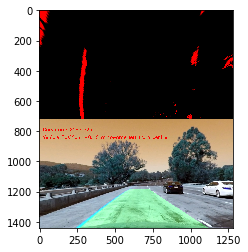

In [19]:
image = cv2.imread('./calibrated_test_images/test1.jpg')

output_image = advancedLaneDetection.pipeline(image)

print(output_image.shape)
plt.imshow(output_image)
plt.show()